# Linear Regression  on a Combined Cycle Power Plant (CCPP) data
## Dataset description

The dataset contains 5281 data points collected from a Combined Cycle Power Plant over 6 years (2006-2011), when the power plant was set to work with full load. Features consist of hourly average ambient variables Temperature (AT), Ambient Pressure (AP), Relative Humidity (RH) and Exhaust Vacuum (V) to predict the net hourly electrical energy output (PE)  of the plant.

A combined cycle power plant (CCPP) is composed of gas turbines (GT), steam turbines (ST) and heat recovery steam generators. In a CCPP, the electricity is generated by gas and steam turbines, which are combined in one cycle, and is transferred from one turbine to another. While the Vacuum has effect on the Steam Turbine, the other three of the ambient variables effect the GT performance.

In [1]:
# to get in-line plots
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
import scipy as sp
from scipy import stats
import pandas as pd

from sklearn.feature_selection import SequentialFeatureSelector

from tabulate import tabulate

import time

## Import Data
Load the data from a .csv file and print data column names.

**TO DO:** insert your ID number (matricola)


In [2]:
# Load the data

IDnumber = 2087644
np.random.seed(IDnumber)

filename = "ccpp_Data_clean2019.csv"

df = pd.read_csv(filename,sep=";")

col_names = df.columns
print(col_names)

data = df.values

Index(['AT', 'V', 'AP', 'RH', 'PE'], dtype='object')


# A quick overview of data

To inspect the data you can use the method describe()

In [3]:
data_description = stats.describe(data)
print(data_description)

#data.shape

#for more interesting visualization: use pandas!
print(data)

DescribeResult(nobs=5281, minmax=(array([  1.81,  25.36, 992.89,  25.56, 420.26]), array([  37.11,   81.56, 1033.29,  100.16,  495.23])), mean=array([  19.67317553,   54.31940163, 1013.22432115,   73.38815187,
        454.31701004]), variance=array([ 56.0327041 , 161.7733201 ,  35.2083789 , 217.43618617,
       291.84459771]), skewness=array([-0.13713412,  0.19522075,  0.24934713, -0.43467097,  0.29846615]), kurtosis=array([-1.04662553, -1.45165813,  0.01128758, -0.43044229, -1.05785395]))
[[  23.97   63.86 1018.09   57.62  441.65]
 [  20.63   43.77 1010.71   62.34  448.25]
 [  23.63   73.18 1012.29   88.81  437.7 ]
 ...
 [  16.65   49.69 1014.01   91.    460.03]
 [  13.19   39.18 1023.67   66.78  469.62]
 [  31.32   74.33 1012.92   36.48  429.57]]


# Split data in training, validation and test sets



Given $m$ total data, keep $m_t$ data as training data, $m_{val}:=m_{tv}-m_t$ as validation data and $m_{test}:=m - m_{val} - m_t = m-m_{tv}$ for test data. For instance one can take $m_t=m/3$ of the data as training, $m_{val}=m/3$  validation and $m_{test}=m/3$ as testing. Let us define as define

$\bullet$ $S_{t}$ the training data set

$\bullet$ $S_{val}$ the validation data set

$\bullet$ $S_{test}$ the testing data set


The reason for this splitting is as follows:

TRAINING DATA: The training data are used to compute the training loss
$$
L_S(h) = \frac{1}{m_t} \sum_{z_i \in S_{t}} \ell(h,z_i)
$$
which is used to estimate $h$ in a given model class ${\cal H}$.
i.e. 
$$
\hat h = {\rm arg\; min}_{h \in {\cal H}} \, L_S(h)
$$

VALIDATION DATA: Validation data are used when different model classes are present (e.g. of different complexity such as linear regression which used a different number $d_j$ of features $x_1$,...$x_{d_j}$ in the model). In general, with more features one can better fit the training set, so one has to choose which one is the "best" complexity. Let ${\cal H}_{d_j}$ be the space of models as a function of the complexity $d_j$ and let 
$$
\hat h_{d_j} = {\rm arg\; min}_{h \in {\cal H}_{d_j}} \, L_S(h)
$$

One can estimate the generalization error for model $\hat h_{d_j}$ as follows:
$$
L_{{\cal D}}(\hat h_{d_j}) \simeq \frac{1}{m_{val}} \sum_{ z_i \in S_{val}} \ell(\hat h_{d_j},z_i)
$$
and then choose the complexity which achieves the best estimate of the generalization error
$$
\hat d: = {\rm arg\; min}_{d_j} \,\frac{1}{m_{val}} \sum_{ z_i \in S_{val}} \ell(\hat h_{d_j},z_i)
$$

TESTING DATA: Last, the test data set can be used to estimate the performance of the final estimated model
$\hat h_{\hat d_j}$ using:
$$
L_{{\cal D}}(\hat h_{\hat d_j}) \simeq \frac{1}{m_{test}} \sum_{ z_i \in S_{test}} \ell(\hat h_{\hat d_j},z_i)
$$


**TO DO**: split the data in training, validation and test sets (suggestion: use $m_t=m_{val} = \lfloor\frac{m}{3}\rfloor$, $m_{test} = m-m_t-m_{val}$)

In [4]:
#get number of total samples
num_total_samples = data.shape[0]

print("Total number of samples: "+str(num_total_samples))

#size of each chunk of data for training, validation, testing
size_chunk = int(num_total_samples/3.)

print("Size of each chunk of data: "+str(size_chunk))

#shuffle the data
np.random.shuffle(data)

#training data

X_training = data[:size_chunk,:4]
Y_training = data[:size_chunk, 4]
print("Training data input size: "+str(X_training.shape))
print("Training data output size: "+str(Y_training.shape))

#validation data, to be used to choose among different models
X_validation = data[size_chunk:size_chunk*2, :4]
Y_validation = data[size_chunk:size_chunk*2, 4]
print("Validation data input size: "+str(X_validation.shape))
print("Validation data ouput size: "+str(Y_validation.shape))

#test data, to be used to estimate the true loss of the final model(s)
X_test = data[size_chunk*2:,:4]
Y_test = data[size_chunk*2:,4]
print("Test data input size: "+str(X_test.shape))
print("Test data output size: "+str(Y_test.shape))

Total number of samples: 5281
Size of each chunk of data: 1760
Training data input size: (1760, 4)
Training data output size: (1760,)
Validation data input size: (1760, 4)
Validation data ouput size: (1760,)
Test data input size: (1761, 4)
Test data output size: (1761,)


# Data Normalization

It is common practice in Statistics and Machine Learning to scale the data (= each variable) so that it is centered (zero mean) and has standard deviation equal to $1$. This helps in terms of numerical stability (conditioning) of the (inverse) problems of estimating the ERM model (the coefficients of the linear regression in this case), as well as to give the same scale to all the coefficients. 

In [5]:
# standardize the input matrix
from sklearn import preprocessing

scaler = preprocessing.StandardScaler().fit(X_training)
X_training = scaler.transform(X_training)
print("Mean of the training input data:"+str(X_training.mean(axis=0)))
print("Std of the training input data:"+str(X_training.std(axis=0)))
X_validation = scaler.transform(X_validation) # use the same transformation on validation data
print("Mean of the validation input data:"+str(X_validation.mean(axis=0)))
print("Std of the validation input data:"+str(X_validation.std(axis=0)))
X_test = scaler.transform(X_test) # use the same transformation on test data
print("Mean of the test input data:"+str(X_test.mean(axis=0)))
print("Std of the test input data:"+str(X_test.std(axis=0)))



Mean of the training input data:[-9.38643103e-17 -1.06985128e-16  1.30602599e-14  8.88178420e-17]
Std of the training input data:[1. 1. 1. 1.]
Mean of the validation input data:[ 0.03337479  0.02454477  0.03221151 -0.02122393]
Std of the validation input data:[1.02135897 1.00043068 1.00291527 1.00186622]
Mean of the test input data:[ 0.03019271  0.02996941  0.01414942 -0.00107231]
Std of the test input data:[1.01356404 1.01118956 0.98680802 0.98331654]


# Model Training 

The model is trained (= estimated) minimizing the empirical error
$$
L_S(h) := \frac{1}{m_t} \sum_{z_i \in S_{t}} \ell(h,z_i)
$$
where $z_i = (x_i,y_i)$.
When the loss function is the quadratic loss
$$
\ell(h,z) := (y - h(x))^2
$$
we define  the Residual Sum of Squares (RSS) as
$$
RSS(h):= \sum_{z_i \in S_{t}} \ell(h,z_i) = \sum_{z_i \in S_{t}} (y_i - h(x_i))^2
$$ so that the training error becomes
$$
L_S(h) = \frac{RSS(h)}{m_t}
$$

We recal that, for linear models we have $h(x) = <w,x>$ and the Empirical error $L_S(h)$ can be written
in terms of the vector of parameters $w$ in the form
$$
L_S(w) = \frac{1}{m_t}(y - Xw)^T(y-Xw) =  \frac{1}{m_t} \|y - X w\|^2
$$
where $y$ is the vector whose $i-th$ element is the output datum $y_i$ and $X$ is the matrix whose $i-$th row is the input vector $x_i^\top$.

The least squares solution is given by the expression
$$
\hat w = {\rm arg\;min}_w L_S(w) = (X^\top X)^{-1} X^\top Y
$$
When the matrix $X$ is not invertible, the solution can be computed using the Moore-Penrose pseudonverse $(X^\top X)^{\dagger}$ of $(X^\top X)$
$$
\hat w = (X^\top X)^{\dagger} X^\top Y
$$


 In practice some of the singular values may be very small (e.g. $<1e-12$). Therefore it makes sense to 
 first approximate the matrix $A$ truncating the SVD and then using the pseudoinverse formula.
 
 More specifically, let us postulate that, given a threshold $T_h$ (e.g $=1e-12$), we have $\sigma_i<T_h$, for $i=\hat r + 1,..,r$. Then we can approximate (by SVD truncation) $A$ using:
 
 $$A = USV^\top =U \,{\rm diag}\{s_1,s_2,..,s_r\}\, V^\top \simeq \hat A_r = U\,{\rm diag}\{s_1,s_2,..,s_{\hat r}, 0,..,0\}\,V^\top
 $$
 So that 
 $$
 A^\dagger \simeq \hat A_r^\dagger:= V \,{\rm diag}\{1/s_1,1/s_2,..,1/s_{\hat r}, 0,..,0\}\, U^\top
 $$
 
 The linear regression coefficients can be computed directly using the numyp.linalg.lstsq function
  
 **TO DO**: compute the linear regression coefficients using the numpy.linalg.lstsq function

In [6]:
#compute linear regression coefficients for training data

#add a 1 at the beginning of each sample for training, validation, and testing
m_training = len(X_training)
X_training = np.hstack((np.ones((m_training,1)),X_training))

m_validation = len(X_validation)
X_validation = np.hstack((np.ones((m_validation,1)),X_validation))

m_test = len(X_test)
X_test = np.hstack((np.ones((m_test,1)),X_test))

# Compute the coefficients for linear regression (LR) using linalg.lstsq
w_np, RSS_tr_np, rank_X_tr, sv_X_tr = np.linalg.lstsq(X_training,Y_training,rcond=None)

print("LR coefficients with numpy lstsq: "+ str(w_np))

# compute Residual sums of squares by hand
print("RSS with numpy lstsq: "+str(RSS_tr_np))
print("Empirical risk with numpy lstsq:"+str(RSS_tr_np/m_training))


LR coefficients with numpy lstsq: [ 4.54436949e+02 -1.46135472e+01 -2.99816625e+00  3.96771752e-01
 -2.30674050e+00]
RSS with numpy lstsq: [36054.29359867]
Empirical risk with numpy lstsq:[20.48539409]


## Data prediction 

Compute the output predictions on both training and validation set and compute the Residual Sum of Squares (RSS) defined above, and the Emprical Loss. Compute also the quantity $R^2$ where
$$
R^2 = 1 - \frac{\sum_{z_i \in S_t} (\hat y_i - y_i)^2}{\sum_{z_i \in S_t} (y_i - \bar y)^2} \quad \quad \bar y = \frac{1}{m_t} \sum_{z_i \in S_t} y_i
$$
is the so-called "Coefficient of determination" (COD)

**TO DO**: Compute these quantities on  training, validation and test sets.


In [7]:
#compute predictions on training set, validation set, and test set
prediction_training = np.dot(X_training,w_np)
prediction_validation = np.dot(X_validation,w_np)
prediction_test = np.dot(X_test,w_np)


#what about the RSS and loss for points in the validation data?
RSS_training = np.sum((Y_training-prediction_training)**2, axis=0)
RSS_validation = np.sum((Y_validation-prediction_validation)**2, axis=0)
RSS_test = np.sum((Y_test-prediction_test)**2, axis=0)

print("RSS on validation data: "+str(RSS_validation))
print("Loss estimated from validation data:"+str(RSS_validation/m_validation))

#another measure of how good our linear fit is given by the following (that is 1 - R^2)
#compute R^2 for training, validation, and test set
R_measure_training = RSS_training/np.sum((prediction_training-np.average(prediction_training, axis=0))**2, axis=0)
R_measure_validation = RSS_validation/np.sum((prediction_validation-np.average(prediction_validation, axis=0))**2, axis=0)
R_measure_test = RSS_test/np.sum((prediction_test-np.average(prediction_test, axis=0))**2, axis=0)

print("Measure on Training Data (1-R^2):"+str(R_measure_training))
print("Measure on Validation Data(1-R^2):"+str(R_measure_validation))
print("Measure on Test Data(1-R^2):"+str(R_measure_test))

RSS on validation data: 36641.730199565776
Loss estimated from validation data:20.81916488611692
Measure on Training Data (1-R^2):0.07696698806727657
Measure on Validation Data(1-R^2):0.07525047047226788
Measure on Test Data(1-R^2):0.07782169738177507


## ... and plot:


### (1) output predictions on training  data

Note that in the following plot and in the analogous plots below the data is permuted so that the predictions are increasing with the index of the instance in the plot. **This is just to make the plot look nice!**

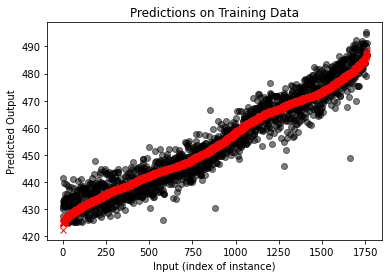

In [8]:
# Plot predictions on Training data 
plt.figure()

#the following is just for nice plotting, not required: it sorts the predictions by value so that they fall on
# a line and it's easier to spot the differences
sorting_permutation = sorted(range(len(prediction_training[0:m_training])), key=lambda k: prediction_training[0:m_training][k])
plt.plot(Y_training[sorting_permutation], 'ko', alpha=0.5)
plt.plot(prediction_training[sorting_permutation], 'rx')

plt.xlabel('Input (index of instance)')
plt.ylabel('Predicted Output')
plt.title('Predictions on Training Data')
plt.show()

### (2) output predictions on validation  data

Plot predictions on validation data.

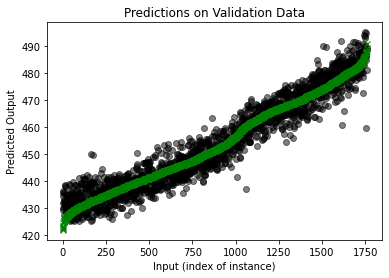

In [9]:
# Plot predictions on validation data 
plt.figure()

#the following is just for nice plotting, not required: it sorts the predictions by value so that they fall on
# a line and it's easier to spot the differences
sorting_permutation = sorted(range(len(prediction_validation[0:m_validation])), key=lambda k: prediction_validation[0:m_validation][k])
plt.plot(Y_validation[sorting_permutation], 'ko', alpha=0.5)
plt.plot(prediction_validation[sorting_permutation], 'gx')


plt.xlabel('Input (index of instance)')
plt.ylabel('Predicted Output')
plt.title('Predictions on Validation Data')
plt.show()

# Removing some features

Perform same as above removing 1 feature that you think may not be as important as the other ones for prediction; recall that, since the data has been normalized, may be done by looking at the weights of each feature in the learned model.

**TO DO**: repeat the learning procedure after having removed 1 feature that you considered less important and explain the choice of which regressors to be removed.

**EXPLANATION**: we remove the third column (corresponding to the Ambient Pressure AP) since it is the column with smaller weight in absolute value, so it does contribute less compared to the others.

In [10]:
start_time = time.time()
# reduced design matrix
# since the column with the smaller weight is the third (corresponding to the Ambient Pressure AP), we remove it from the data
df1 = df.drop(['AP','PE'],axis=1, inplace=False)
selected_features = df1.columns
print(selected_features)

# in X it is the fourth column since we added a column of 1's in a previous step
X_training_reduced = np.delete(X_training, 3, axis=1)
X_validation_reduced = np.delete(X_validation, 3, axis=1)
X_test_reduced = np.delete(X_test, 3, axis=1)

w_np_reduced, RSS_tr_np_reduced, rank_Xtr_reduced, sv_Xtr_reduced = np.linalg.lstsq(X_training_reduced,Y_training,rcond=None)

print(); print("LR coefficients of reduced model:"+str(w_np_reduced))

# Compute predictions
prediction_training_reduced = np.dot(X_training_reduced,w_np_reduced)
prediction_validation_reduced = np.dot(X_validation_reduced,w_np_reduced)
prediction_test_reduced = np.dot(X_test_reduced,w_np_reduced)

#Compute Training Error
RSS_training_reduced = np.sum((Y_training-prediction_training_reduced)**2, axis=0)

print("RSS on training data of reduced model:"+str(RSS_training_reduced))
print("Loss estimated from training data of reduced model:"+str(RSS_training_reduced/m_training))

# Compute Validation Error
RSS_validation_reduced = np.sum((Y_validation-prediction_validation_reduced)**2, axis=0)

print("RSS on validation data of reduced model:"+str(RSS_validation_reduced))
print("Loss estimated from validation data of reduced model:"+str(RSS_validation_reduced/m_validation))

# Compute Test Error
RSS_test_reduced = np.sum((Y_test-prediction_test_reduced)**2, axis=0)

print("RSS on test data of reduced model:"+str(RSS_test_reduced))
print("Loss estimated from test data of reduced model:"+str(RSS_test_reduced/m_test))


#another measure of how good our linear fit is given by the following (that is 1 - R^2)
# Compute Training, Validation, and Test Error as 1-R^2
R_measure_training_reduced = RSS_training_reduced/np.sum((prediction_training_reduced-np.average(prediction_training_reduced, axis=0))**2, axis=0)
print("Measure on training data of reduced model:"+str(R_measure_training_reduced))
R_measure_validation_reduced = RSS_validation_reduced/np.sum((prediction_validation_reduced-np.average(prediction_validation_reduced, axis=0))**2, axis=0)
print("Measure on validation data of reduced model:"+str(R_measure_validation_reduced))
R_measure_test_reduced = RSS_test_reduced/np.sum((prediction_test_reduced-np.average(prediction_test_reduced, axis=0))**2, axis=0)
print("Measure on test data of reduced model:"+str(R_measure_test_reduced))

table = [["R training",R_measure_training,R_measure_training_reduced],["R validation",R_measure_validation,R_measure_validation_reduced],["R test",R_measure_test,R_measure_test_reduced],
        ["RSS training",RSS_training,RSS_training_reduced],["RSS validation",RSS_validation,RSS_validation_reduced],["RSS test",RSS_test,RSS_test_reduced],
        ["Loss from training data", RSS_training/m_training,RSS_training_reduced/m_training], ["Loss from validation data", RSS_validation/m_validation,RSS_validation_reduced/m_validation], ["Loss from test data", RSS_test/m_test,RSS_test_reduced/m_test]
        ]
print(); print(tabulate(table,headers=["non reduced","reduced"],numalign="right"))

print("--- %s seconds ---" % (time.time() - start_time))


Index(['AT', 'V', 'RH'], dtype='object')

LR coefficients of reduced model:[454.43694886 -14.92820969  -2.92449048  -2.41934097]
RSS on training data of reduced model:36254.029065869894
Loss estimated from training data of reduced model:20.59888015106244
RSS on validation data of reduced model:36880.75807445798
Loss estimated from validation data of reduced model:20.95497617866931
RSS on test data of reduced model:37954.05949362068
Loss estimated from test data of reduced model:21.552560757308736
Measure on training data of reduced model:0.0774263873345772
Measure on validation data of reduced model:0.07584996094569464
Measure on test data of reduced model:0.07788892742416996

                             non reduced    reduced
-------------------------  -------------  ---------
R training                      0.076967  0.0774264
R validation                   0.0752505    0.07585
R test                         0.0778217  0.0778889
RSS training                     36054.3      36254
RS

## Plot prediction on validation data for the reduced model

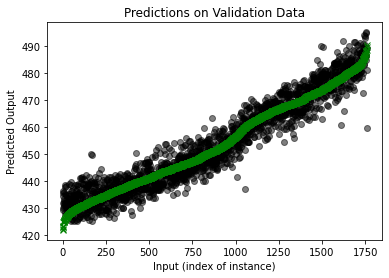

In [11]:
plt.figure()

#the following is just for nice plotting, not required: it sorts the predictions by value so that they fall on
# a line and it's easier to spot the differences
sorting_permutation = sorted(range(len(prediction_validation_reduced[0:m_validation])), key=lambda k: prediction_validation_reduced[0:m_validation][k])
plt.plot(Y_validation[sorting_permutation], 'ko', alpha=0.5)
plt.plot(prediction_validation_reduced[sorting_permutation], 'gx')


plt.xlabel('Input (index of instance)')
plt.ylabel('Predicted Output')
plt.title('Predictions on Validation Data')
plt.show()

# MODEL SELECTION 

**TO DO**: Based on the results of the estimated models (full model and reduced model) **on the validation data** which one would you choose? Explain the choice. Is this choice supported by the predictions of the estimated models **on the test data**? Explain your reasoning.

**ANSWER**:
Based on the measures we computed (loss,RSS and R) I would choose the reduced model, though it has slightly worst measures than the full model. The choice is motivated by the fact that the difference between $R^2$ and the loss of the two models are small (for $R^2$ fourth order of magnitude and for the loss second order, but since it is a percentage it is basically irrelevant), so the reduced complexity of the model with three features weights more on the balance of pros and cons. <br> Though the choice has been made on the validation data, it is still backed by the results on the test data: the difference is more marked, but it is still small enough to justify to have less features in the model.


## Ordinary Least-Squares using scikit-learn

A fast way to compute the LS estimate is through sklearn.linear_model

In [12]:
# Remove the ''ones'' column in the features matrix (sklearn inserts it automatically)
X_training = X_training[:,1:]
X_test = X_test[:,1:]


In [13]:
from sklearn import linear_model

lin_reg = linear_model.LinearRegression()  # build the object LinearRegression
lin_reg.fit(X_training, Y_training)  # estimate the LS coefficients
print("Intercept:", lin_reg.intercept_)
print("Least-Squares Coefficients:", lin_reg.coef_)
prediction_training = lin_reg.predict(X_training)  # predict output values on training set
prediction_test = lin_reg.predict(X_test)  # predict output values on test set
print("Measure on training data:", 1-lin_reg.score(X_training, Y_training))

Intercept: 454.43694886363636
Least-Squares Coefficients: [-14.61354718  -2.99816625   0.39677175  -2.3067405 ]
Measure on training data: 0.07146643204486847
